<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


<h1>Practice: Neural Networks with One Hidden Layer: Noisy XOR</h1>


<h2>Objective</h2><ul><li> How to create a neural network model with multiple neurons.</li></ul> 


<h2>Table of Contents</h2>
<p>In this lab, you will see how many neurons it takes to classify noisy XOR data with one hidden layer neural network.</p>

<ul>
    <li><a href="#Model">Neural Network Module and Training Function</a></li>
    <li><a href="#Makeup_Data">Make Some Data</a></li>
    <li><a href="#One">One Neuron</a></li>
    <li><a href="#Two">Two Neurons</a></li>
    <li><a href="#Three">Three Neurons</a></li>
</ul>
<p>Estimated Time Needed: <strong>25 min</strong></p>
<hr>


<h2>Preparation</h2>


We'll need the following libraries


In [1]:
# Import the libraries we need for this lab



import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
from torch.utils.data import Dataset, DataLoader

Use the following function to plot the data: 


In [2]:
# Plot the data

def plot_decision_regions_2class(model,data_set):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#00AAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#00AAFF'])
    X = data_set.x.numpy()
    y = data_set.y.numpy()
    h = .02
    x_min, x_max = X[:, 0].min() - 0.1 , X[:, 0].max() + 0.1 
    y_min, y_max = X[:, 1].min() - 0.1 , X[:, 1].max() + 0.1 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    XX = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])

    yhat = np.logical_not((model(XX)[:, 0] > 0.5).numpy()).reshape(xx.shape)
    plt.pcolormesh(xx, yy, yhat, cmap=cmap_light)
    plt.plot(X[y[:, 0] == 0, 0], X[y[:, 0] == 0, 1], 'o', label='y=0')
    plt.plot(X[y[:, 0] == 1, 0], X[y[:, 0] == 1, 1], 'ro', label='y=1')
    plt.title("decision region")
    plt.legend()

Use the following function to calculate accuracy: 


In [3]:
# Calculate the accuracy

def accuracy(model, data_set):
    return np.mean(data_set.y.view(-1).numpy() == (model(data_set.x)[:, 0] > 0.5).numpy())

<!--Empty Space for separating topics-->


<a name="Model"><h2 id="Model">Neural Network Module and Training Function</h2></a>


Define the neural network module or class: 


In [4]:
# Define the class Net with one hidden layer 

class Net(nn.Module):
    
    # Constructor
    def __init__(self, D_in, H, D_out):
        super(Net, self).__init__()
        #hidden layer 
        self.linear1 = nn.Linear(D_in, H)
        #output layer 
        self.linear2 = nn.Linear(H, D_out)

    # Prediction    
    def forward(self, x):
        x = torch.sigmoid(self.linear1(x))  
        x = torch.sigmoid(self.linear2(x))
        return x

Define a function to train the model: 


In [5]:
# Define the train model

def train(data_set, model, criterion, train_loader, optimizer, epochs=5):
    COST = []
    ACC = []
    for epoch in range(epochs):
        total=0
        for x, y in train_loader:
            optimizer.zero_grad()
            yhat = model(x)
            loss = criterion(yhat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #cumulative loss 
            total+=loss.item()
        ACC.append(accuracy(model, data_set))
        COST.append(total)
        
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)
    
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # we already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    plt.show()

    return COST

<!--Empty Space for separating topics-->


<a name="Makeup_Data"><h2 id="Makeup_Data">Make Some Data</h2></a>


Dataset class:


In [6]:
# Define the class XOR_Data

class XOR_Data(Dataset):
    
    # Constructor
    def __init__(self, N_s=100):
        self.x = torch.zeros((N_s, 2))
        self.y = torch.zeros((N_s, 1))
        for i in range(N_s // 4):
            self.x[i, :] = torch.Tensor([0.0, 0.0]) 
            self.y[i, 0] = torch.Tensor([0.0])

            self.x[i + N_s // 4, :] = torch.Tensor([0.0, 1.0])
            self.y[i + N_s // 4, 0] = torch.Tensor([1.0])
    
            self.x[i + N_s // 2, :] = torch.Tensor([1.0, 0.0])
            self.y[i + N_s // 2, 0] = torch.Tensor([1.0])
    
            self.x[i + 3 * N_s // 4, :] = torch.Tensor([1.0, 1.0])
            self.y[i + 3 * N_s // 4, 0] = torch.Tensor([0.0])

            self.x = self.x + 0.01 * torch.randn((N_s, 2))
        self.len = N_s

    # Getter
    def __getitem__(self, index):    
        return self.x[index],self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len
    
    # Plot the data
    def plot_stuff(self):
        plt.plot(self.x[self.y[:, 0] == 0, 0].numpy(), self.x[self.y[:, 0] == 0, 1].numpy(), 'o', label="y=0")
        plt.plot(self.x[self.y[:, 0] == 1, 0].numpy(), self.x[self.y[:, 0] == 1, 1].numpy(), 'ro', label="y=1")
        plt.legend()

Dataset object:


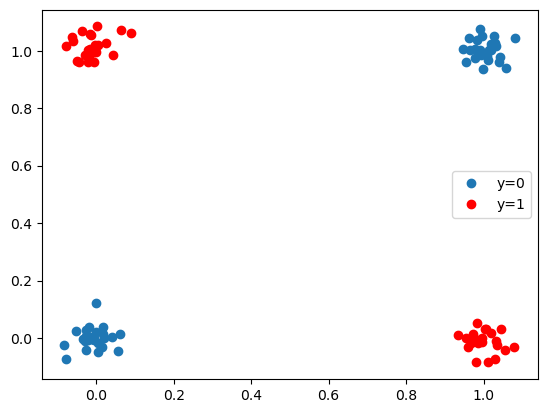

In [7]:
# Create dataset object

data_set = XOR_Data()
data_set.plot_stuff()

<!--Empty Space for separating topics-->


<a name="One"><h2 id="One">One Neuron</h2></a>


<h3>Try</h3>


Create a neural network <code>model</code> with one neuron. Then, use the following code to train it:


In [8]:
# Practice: create a model with one neuron

# Type your code here

model = Net(2, 1, 1)

Double-click <b>here</b> for the solution.

<!-- 
model = Net(2, 1, 1)
-->


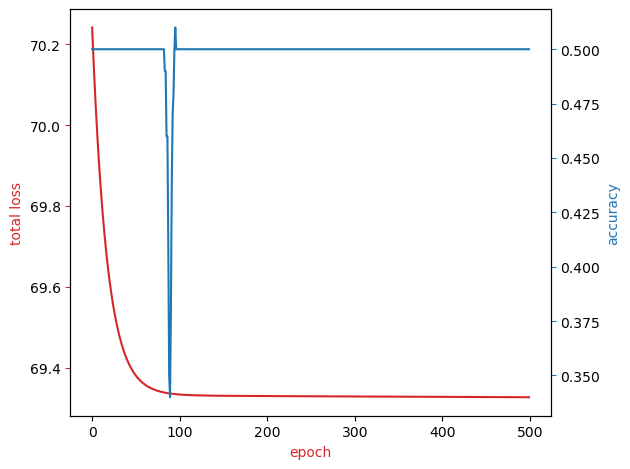

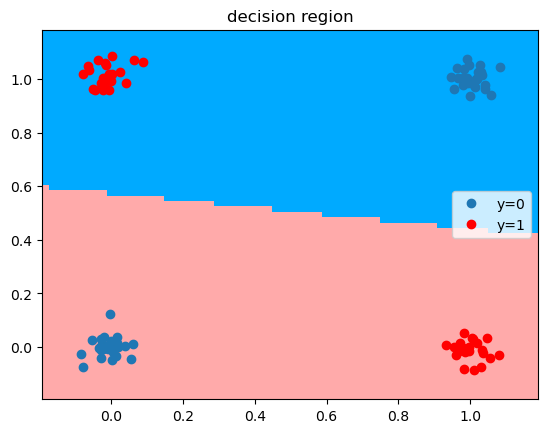

In [9]:
# Train the model

learning_rate = 0.001
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
train_loader = DataLoader(dataset=data_set, batch_size=1)
LOSS12 = train(data_set, model, criterion, train_loader, optimizer, epochs=500)
plot_decision_regions_2class(model, data_set)

<!--Empty Space for separating topics-->


<a name="Two"><h2 id="Two">Two Neurons</h2></a>


<h3>Try</h3>


Create a neural network <code>model</code> with two neurons. Then, use the following code to train it:


In [10]:
# Practice: create a model with two neuron

# Type your code here

model = Net(2, 2, 1)

Double-click <b>here</b> for the solution.

<!-- 
model = Net(2, 2, 1)
-->


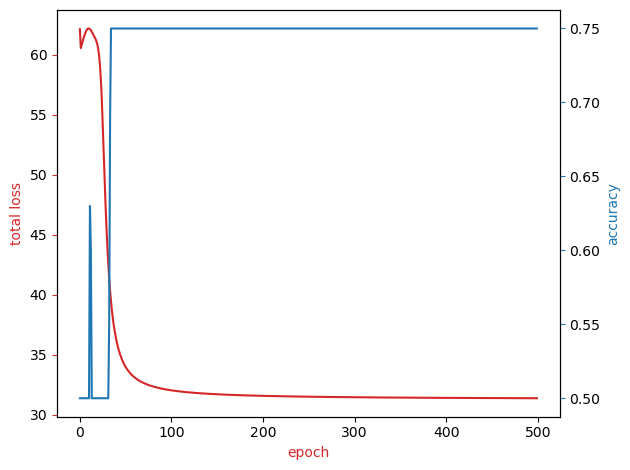

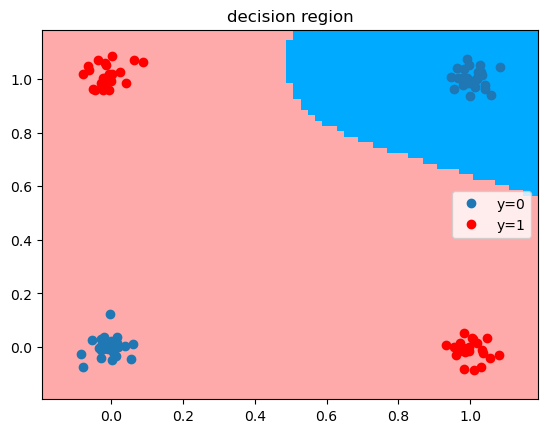

In [11]:
# Train the model

learning_rate = 0.1
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
train_loader = DataLoader(dataset=data_set, batch_size=1)
LOSS12 = train(data_set, model, criterion, train_loader, optimizer, epochs=500)
plot_decision_regions_2class(model, data_set)

<!--Empty Space for separating topics-->


<a name="Three"><h2 id="Three">Three Neurons</h2></a>


<h3>Try</h3>


Create a neural network <code>model</code> with three neurons. Then, use the following code to train it:


In [12]:
# Practice: create a model with two neuron

# Type your code here

model = Net(2, 3, 1)

Double-click <b>here</b> for the solution.

<!-- 
model = Net(2, 3, 1)
-->


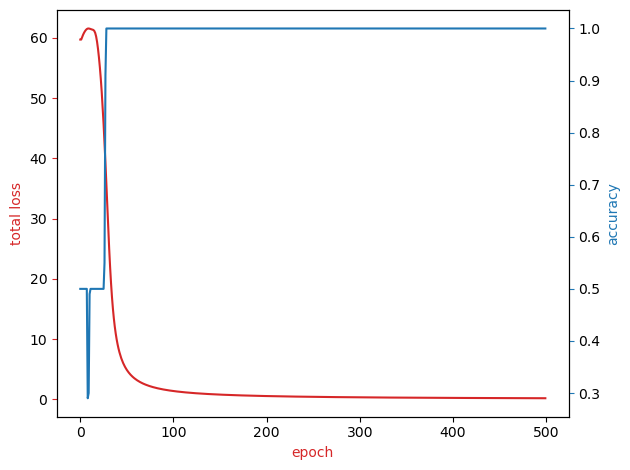

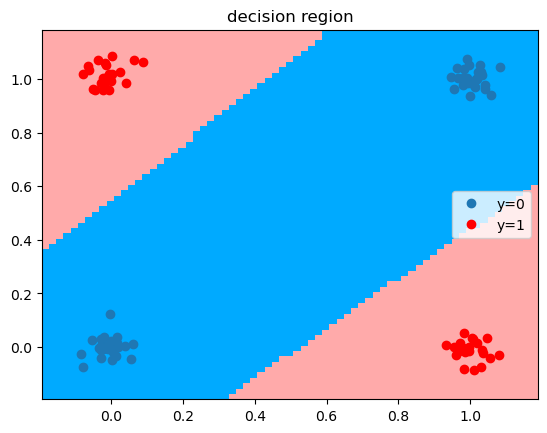

In [13]:
# Train the model

learning_rate = 0.1
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
train_loader = DataLoader(dataset=data_set, batch_size=1)
LOSS12 = train(data_set, model, criterion, train_loader, optimizer, epochs=500)
plot_decision_regions_2class(model, data_set)




<a href="https://dataplatform.cloud.ibm.com/registration/stepone?utm_source=skills_network&utm_content=in_lab_content_link&utm_id=Lab-IBMDeveloperSkillsNetwork-DL0110EN-SkillsNetwork&context=cpdaas&apps=data_science_experience%2Cwatson_machine_learning"><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0110EN-SkillsNetwork/Template/module%201/images/Watson_Studio.png"></a>


<!--Empty Space for separating topics-->


<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD. 


Other contributors: <a href="https://www.linkedin.com/in/michelleccarey/">Michelle Carey</a>, <a href="https://www.linkedin.com/in/jiahui-mavis-zhou-a4537814a">Mavis Zhou</a>


<!--
## Change Log

|  Date (YYYY-MM-DD) |  Version | Changed By  |  Change Description |
|---|---|---|---|
| 2020-09-23  | 2.0  | Shubham  |  Migrated Lab to Markdown and added to course repo in GitLab |
-->


<hr>



## <h3 align="center"> &#169; IBM Corporation. All rights reserved. <h3/>
